# A computational framework for the efficient formulation and calibration of large-scale, thermodynamically consistent kinetic models and its application

## Abstract

## Introduction

Cells use signal transduction to respond to extracellular cues. Extracellular ligands bind to RTKs that initiate phosphorylation cascades. Depending on protein abundance, different protein complexes will be assembled, which determines which part of downstream signaling will be activated. In contrast to phosphorylation, assembly of protein complexes does not consume energy. Consumption of energy can be checked via wegscheider cycle conditions. Enumerating all cycles is an NP-hard problem, so structured approach is necessary to ensure energy conservation. Faeder et al have introduced thermodynamic rule based modelling which derives kinetic rates from the specified gibbs free energies. Binding reactions generated using thermodynamic framework inherently satisfy energy conservation, making them biophysically more plausible. Also allows specification of rules that consume energy, such as phosphorylation or dephosphorylation by explicitely specifying consumption of cellular energy sources such as ATP or NADPH.
Derivation of kinetic rates from gibbs free energies are carried out using arrhenius equation, but more modern formulations exist. Formulation provides an intuition why log-scale is more natural scale for most parameters and why optimization etc works better when log-transformed.

Energy conservation and corresponding wegscheider conditions introduce an constraint on parameters, which may suggest that this yields smaller less complex models. However, thermodynamically sounds models require reversibility of all reactions, which usually leads to more complex models. Specifically, binarization of reactions usually leads to non-reversible reactions that may violate energy conservation. An example for binarization of a reaction would be binding of RAS. RAF has a much higher affinity to gtp loaded Ras (RAS-gtp) compared to gdp loaded Ras (RAS-gdp), so it is tempting to implement a conditional reaction where RAF only binds RAS-gtp, but not RAS-gdp. As RAS is a GTPase, it can hydrolyse the loaded gtp to gdp, converting RAS-gtp to RAS-gdp. This reaction creates a complex in which RAS-gdp is bound to RAF. As the corresponding binding reaction was explicitely not created, the unbinding reaction for RAS-gdp and RAF would necessarily be irreversible and may thus violate energy conservation. Implementing a non-binarized reaction where RAF binds both RAS-gtp and RAS-gdp can easily be done in the thermodynamic framework, where the difference in affinity would be implemented as difference in Gibbs Free Energy, and would be guaranteed to satisfy wegscheider cycle conditions and thus satisfy energy conservation. However, the non-binarized, thermodynamic model needs to account for more species, which may pose computational challenges when the model describes more complex oligomerization processes. 

Tools such as NFSim are particularly suited to simulate 

## Formulating a Thermodynamic Model of RAF inhibition in PySB

First import various classes that are necessary to define rules and initialize the model

In [1]:
from pysb import Model, Compartment, Rule, EnergyPattern, Expression
model = Model('thermo_raf');

### Protein Species
As first step of the model construction, we have to define all molecules which we want to account for. In PySB, this is done through using the Monomer class. Each monomer is initialized by a unique identifier, a list of site as well as, optionally, a list of states for each site. Sites without states are typically describe the bonds involved in complex formation, while sites with states can also describe (post-translational) protein modifitations such as mutations or phosphorylation. 

Here, we we will define monomers _BRAF_ and _CRAF_ which both feature the interaction sites _RBD_ (interaction domain with RAS), _mek_ (interaction domain with MEK), _raf_ (dimerization domain) and _rafi_ (inhibitor binding site). For BRAF we also add a mutation sites for the 600th amino acid, which can take values _V_ (valine, wildtype) or _E_ (glutamic acid, oncogenic mutation).

In [2]:
from pysb import Monomer
Monomer('BRAF', ['AA600', 'RBD', 'mek', 'raf', 'rafi'], {'AA600': ['E', 'V']})
Monomer('CRAF', ['RBD', 'mek', 'raf', 'rafi']);

Next, we will specify initial concentrations. For this model, the concentration of all molecular species will be in $\mu\mathrm{M}$. However, we will use protein counts per cell derived from absolute proteomics to inform initial conditions. Accordingly, parameters that define initial concentrations have to be transformed from molecule per cell to $\mu\mathrm{M}$, which is achieved by dividing them by cell volume (here assumed to be $1pL = 10^{-12} L$) and Avogadro constant ($6.022 10^{23}$ molecules) and multiplying with $10^{6}$ to account for the unit prefix $\mu$.

In the following code we first introduce two expressions that define the avogadro constant and cell volume. PySB automatically creates workspace variables with the name of the expressions, which is passed as first argument, that can then later be used as argument to functions or as part of more complex expressions. Next, we introduce two parameter _BRAF_0_ and _CRAF_0_ that define initial abundances as molecules per cell and convert these abundances to concentrations in $\mu\mathrm{M}$ using the expressions _initBRAF_ and _initCRAF_. These expressions are then used to define the initial abundances of two molecular species for CRAF and BRAF. A molecular species is defined by a pattern, which is created by invoking the respective monomer with the state of each site as keyword argument. For initial conditions, the respective patterns have to be explicit, i.e., all states have to defined. Here, we specify that all sites are unbound (denoted by _None_), with the exception of the the _AA600_ site, for which we have to pick ony of the previously specified states, where we pick the oncogenic variant denoted by _E_.

In [3]:
from pysb import Parameter, Expression, Initial
import sympy as sp

# define Avogadro constant and volume as hardcoded expressions
Expression('N_Avogadro', sp.Float(6.02214076e+23))
Expression('volume', sp.Float(1e-12))

# define initial abundance parameters 
Parameter('BRAF_0', 0.0)
Parameter('CRAF_0', 0.0)

# convert initial abundances to concentrations
Expression('initBRAF', 1000000.0*BRAF_0/(N_Avogadro*volume))
Expression('initCRAF', 1000000.0*CRAF_0/(N_Avogadro*volume))

# define initial molecular species
Initial(BRAF(AA600='E', RBD=None, mek=None, raf=None, rafi=None), initBRAF)
Initial(CRAF(RBD=None, mek=None, raf=None, rafi=None), initCRAF);

### Protein Interactions
In rule-based modeling, all dynamic interactions are specified as rules. Rules are generalizations of biochemical reactions and their action is defined by a reactant pattern and a product pattern. When applied to a molecular species, the action of the rule, i.e., the respective biochemical reaction, is implemented by replacing one occurence of the reactant pattern by the product pattern in a molecular species. The reactant pattern and product pattern do not have to be explicit and a single rule can define multiple different biochemical reactions, depending in how often and in how many molecular species the reactant pattern occurs.

Non-thermodynamic rules additionally require forward and, if applicable, reverse reaction rates. In contrast, thermodynamic rules are specified in terms of activation energy and the phenomenological constant $\phi$, which encodes whether changes in free energy affect forwards or reverse rates. For thermodynamic rules, the reaction rate also depends on EnergyPatterns that may apply to educts or products of the reaction. This means that all reactions generated by non-thermodynamic rules have the same reaction rates, unless the rate is a local function. In contrast, reactions generated by thermodynamic rules can have context dependent reaction rates.

In the following we will specify the dimerization of RAF molecules. We introduce three parameters, the forward rate $k_f$, the dissociation constant $k_D$ and the thermodynamic parameter $\phi$. 

In [4]:
Parameter('bind_RAF_RAF_Ea', 10.0)
Parameter('bind_RAF_RAF_dG', 0.01)
Parameter('bind_RAF_RAF_phi', 1.0)

Expression('Ea0_bind_RAF_RAF', -bind_RAF_RAF_phi*bind_RAF_RAF_dG - bind_RAF_RAF_Ea);

To construct homo- and heterodimerization rules for all RAF paralogs, we use itertools to loop over all combinations of BRAF and CRAF. This assumes equal affinities and dynamics for all proteins.

In [5]:
import itertools as itt

for RAF1, RAF2 in itt.combinations_with_replacement([BRAF, CRAF], 2):
    Rule(f'{RAF1.name}_and_{RAF2.name}_bind_and_dissociate', 
         RAF1(raf=None) + RAF2(raf=None) | RAF1(raf=1) % RAF2(raf=1), 
         bind_RAF_RAF_phi, Ea0_bind_RAF_RAF, energy=True)
    EnergyPattern(f'ep_bind_{RAF1.name}_{RAF2.name}', 
                  RAF1(raf=1) % RAF2(raf=1), bind_RAF_RAF_dG);

### RAF inhibitor
Here we introduce a RAF inhibitor RAFi. We assume that the inhibitor is added to the cell medium at some point and quickly diffuses in and out of the cell. As extracellular space is much bigger than the volume of a cell, we can assume an infinite reservoir of molecules on the outside and assume that the intracellular inhibitors concentration will be unaffected by intracellular reactions. Accordingly, we specify the respective initial as constant, which means that the respective molecular species can participate in reactions, but it's concentration will remain constant.

In [6]:
Monomer('RAFi', ['raf'])

Initial(RAFi(raf=None), Parameter('RAFi_0', 0.0), fixed=True);

Next we define binding reactions for RAFi with both BRAF and CRAF, again assuming the same affinities and activation energies for both reactions.

In [7]:
Parameter('bind_RAFi_RAF_Ea', 10.0)
Parameter('bind_RAFi_RAF_dG', 0.01)
Parameter('bind_RAFi_RAF_phi', 1.0)
Expression('Ea0_bind_RAFi_RAF', -bind_RAFi_RAF_phi*bind_RAFi_RAF_dG - bind_RAFi_RAF_Ea)

for RAF in [BRAF, CRAF]:
    Rule(f'RAFi_and_{RAF.name}_bind_and_dissociate', 
         RAFi(raf=None) + RAF(rafi=None) | RAFi(raf=1) % RAF(rafi=1), 
         bind_RAFi_RAF_phi, Ea0_bind_RAFi_RAF, energy=True)
    EnergyPattern(f'ep_bind_{RAF.name}_RAFi', RAFi(raf=1) % RAF(rafi=1), bind_RAFi_RAF_dG);

### Paradoxical Activation
RAF inhibitors inhibit growth for BRAF mutants but promote growth for NRAS mutants. At the strucural level, this can be rationalized by assuming that RAF inhibitors have higher affinity towards drug-unbound RAF dimers and lower affinity towards drug bound RAF dimers. The symmetry conveyed by the no energy consuming nature of molecular binding reactions, implies that RAF inhibitors, at low to medium concentrations, promote dimerization but incompletely inhibit signaling as they only bind to one of the two protomers in a dimer. As MAPK signaling in NRAS mutant cells is mediated by RAF dimers, respective signaling is amplified, leading to increased growth. In the thermodynamic framework, this can be implemented by adding an energy pattern that controls the Gibbs free energy of RAF-RAF-RAFi trimers. Note that we do not specify how these trimers are formed, so the change in energy will equally apply to the rates of all reactions that produce these trimers. In this example, an decrease in energy would equally increase RAF dimerization and inhbitor binding, thus implementing the previously described symmetry.

In [8]:
Parameter('ep_RAF_RAF_mod_RAFi_single_ddG', 0.001)
for RAF1, RAF2 in itt.product([BRAF, CRAF], repeat=2):
    EnergyPattern(f'ep_{RAF1.name}_{RAF2.name}_mod_RAFi_single', 
                  RAF1(raf=1, rafi=None) % RAF2(raf=1, rafi=2) % RAFi(raf=2), ep_RAF_RAF_mod_RAFi_single_ddG);

To implement the protection of the second dimer, we add additional energy patterns that change the Gibbs free energy of RAFi-RAF-RAF-RAFi quatramers.

In [9]:
Parameter('ep_RAF_RAF_mod_RAFi_double_ddG', 1000.0)
for RAF1, RAF2 in itt.combinations_with_replacement([BRAF, CRAF], r=2):
    EnergyPattern(f'ep_{RAF1.name}_{RAF2.name}_mod_RAFi_double', 
                  RAFi(raf=2) % BRAF(raf=1, rafi=2) % BRAF(raf=1, rafi=3) % RAFi(raf=3), 
                  ep_RAF_RAF_mod_RAFi_double_ddG);

We will now load the remainder of the model from a file. Briefly, the full model describes MEK and ERK phosphorylation downstream as well as EGF stimulatable EGFR signaling upstream of RAF signaling. Moreover, it incorporates negative feedback from ERK on both MAPK and EGFR signaling. A comprehensive description of this part of the model is available in REF. Note however, that parts of the model were substantially simplified account for the reduced set of experimental data.

In [10]:
from pysb import Observable, ANY
def extend_model():
    Monomer('RAS', ['raf', 'state'], {'state': ['gdp', 'gtp']})
    Monomer('MEK', ['Dsite', 'phospho', 'raf'], {'phospho': ['p', 'u']})
    Monomer('ERK', ['CD', 'phospho'], {'phospho': ['p', 'u']})
    Monomer('DUSP', ['erk'])

    Parameter('ep_RAF_RAF_mod_RASstategtp_double_ddG', 1000.0)
    Parameter('bind_RASstategtp_RAF_Ea', 10.0)
    Parameter('bind_RASstategtp_RAF_dG', 0.01)
    Parameter('bind_RASstategtp_RAF_phi', 1.0)
    Parameter('bind_RAF_MEKphosphou_Ea', 10.0)
    Parameter('bind_RAF_MEKphosphou_dG', 0.01)
    Parameter('bind_RAF_MEKphosphou_phi', 1.0)
    Parameter('catalyze_RAF_RAFrafiNone_MEK_p_kcat', 10.0)
    Parameter('catalyze_RAFrafiNone_MEK_p_kcat', 10.0)
    Parameter('bind_MEK_ERKphosphou_kf', 10.0)
    Parameter('bind_MEK_ERKphosphou_kD', 0.01)
    Parameter('catalyze_MEKmekiNone_phosphop_ERK_p_kcat', 10.0)
    Parameter('bind_DUSP_ERKphosphop_kf', 10.0)
    Parameter('bind_DUSP_ERKphosphop_kD', 0.01)
    Parameter('synthesize_ERKphosphop_DUSP_ERK_gexpslope', 1000.0)
    Parameter('synthesize_ERKphosphop_DUSP_kdeg', 10.0)
    Parameter('synthesize_ERKphosphop_DUSP_ERK_kM', 0.0)
    Parameter('inhibition_ERKphosphop_RAS_kM', 0.0)
    Parameter('catalyze_PP2A_MEK_u_kcatr', 1.0)
    Parameter('catalyze_DUSP_ERK_u_kcatr', 1.0)
    Parameter('activation_RAS_kcat', 1.0)

    Parameter('RAS_0', 0.0)
    Parameter('MEK_0', 0.0)
    Parameter('ERK_0', 0.0)
    Parameter('EGF_0', 0.0)
    Parameter('DUSP_eq', 10000.0)

    Expression('Ea0_bind_RASstategtp_BRAF', 
               -bind_RASstategtp_RAF_phi*bind_RASstategtp_RAF_dG - bind_RASstategtp_RAF_Ea)
    Expression('Ea0_bind_RASstategtp_CRAF', 
               -bind_RASstategtp_RAF_phi*bind_RASstategtp_RAF_dG - bind_RASstategtp_RAF_Ea)
    Expression('Ea0_bind_BRAF_MEKphosphou', 
               -bind_RAF_MEKphosphou_phi*bind_RAF_MEKphosphou_dG - bind_RAF_MEKphosphou_Ea)
    Expression('Ea0_bind_CRAF_MEKphosphou', 
               -bind_RAF_MEKphosphou_phi*bind_RAF_MEKphosphou_dG - bind_RAF_MEKphosphou_Ea)

    Expression('bind_MEK_ERKphosphou_kr', bind_MEK_ERKphosphou_kD*bind_MEK_ERKphosphou_kf)
    Expression('bind_DUSP_ERKphosphop_kr', bind_DUSP_ERKphosphop_kD*bind_DUSP_ERKphosphop_kf)
    Expression('catalyze_PP2A_MEK_u_kcat', catalyze_PP2A_MEK_u_kcatr*catalyze_RAFrafiNone_MEK_p_kcat)
    Expression('catalyze_DUSP_ERK_u_kcat', catalyze_DUSP_ERK_u_kcatr*catalyze_MEKmekiNone_phosphop_ERK_p_kcat)

    Expression('initMEK', 1000000.0*MEK_0/(N_Avogadro*volume))
    Expression('initERK', 1000000.0*ERK_0/(N_Avogadro*volume))
    Expression('initRAS', 1000000.0*RAS_0/(N_Avogadro*volume)*EGF_0/100.0)

    Observable('modulation_ERKphosphop', ERK(phospho='p'))

    Expression('synthesize_ERKphosphop_DUSP_ERK_kmod', modulation_ERKphosphop*synthesize_ERKphosphop_DUSP_ERK_gexpslope/(modulation_ERKphosphop + synthesize_ERKphosphop_DUSP_ERK_kM) + 1)
    Expression('synthesize_ERKphosphop_DUSP_ksyn', 1.0*DUSP_eq*synthesize_ERKphosphop_DUSP_kdeg*synthesize_ERKphosphop_DUSP_ERK_kmod)
    Expression('inhibition_ERKphosphop_RAS_kmod', activation_RAS_kcat/(modulation_ERKphosphop + inhibition_ERKphosphop_RAS_kM))


    Rule('RASgtp_and_BRAF_bind_and_dissociate', RAS(raf=None, state='gtp') + BRAF(RBD=None) | RAS(raf=1, state='gtp') % BRAF(RBD=1), bind_RASstategtp_RAF_phi, Ea0_bind_RASstategtp_BRAF, energy=True)
    Rule('RASgtp_and_CRAF_bind_and_dissociate', RAS(raf=None, state='gtp') + CRAF(RBD=None) | RAS(raf=1, state='gtp') % CRAF(RBD=1), bind_RASstategtp_RAF_phi, Ea0_bind_RASstategtp_CRAF, energy=True)
    Rule('BRAF_and_uMEK_bind_and_dissociate', BRAF(mek=None) + MEK(phospho='u', raf=None) | BRAF(mek=1) % MEK(phospho='u', raf=1), bind_RAF_MEKphosphou_phi, Ea0_bind_BRAF_MEKphosphou, energy=True)
    Rule('CRAF_and_uMEK_bind_and_dissociate', CRAF(mek=None) + MEK(phospho='u', raf=None) | CRAF(mek=1) % MEK(phospho='u', raf=1), bind_RAF_MEKphosphou_phi, Ea0_bind_CRAF_MEKphosphou, energy=True)
    Rule('BRAF_BRAF_phosphorylates_MEK', MEK(phospho='u', raf=1) % BRAF(RBD=ANY, mek=1, raf=2, rafi=None) % BRAF(RBD=ANY, raf=2) >> MEK(phospho='p', raf=None) + BRAF(RBD=ANY, mek=None, raf=2, rafi=None) % BRAF(RBD=ANY, raf=2), catalyze_RAF_RAFrafiNone_MEK_p_kcat)
    Rule('BRAF_CRAF_phosphorylates_MEK', MEK(phospho='u', raf=1) % BRAF(RBD=ANY, mek=1, raf=2, rafi=None) % CRAF(RBD=ANY, raf=2) >> MEK(phospho='p', raf=None) + BRAF(RBD=ANY, mek=None, raf=2, rafi=None) % CRAF(RBD=ANY, raf=2), catalyze_RAF_RAFrafiNone_MEK_p_kcat)
    Rule('CRAF_BRAF_phosphorylates_MEK', MEK(phospho='u', raf=1) % CRAF(RBD=ANY, mek=1, raf=2, rafi=None) % BRAF(RBD=ANY, raf=2) >> MEK(phospho='p', raf=None) + CRAF(RBD=ANY, mek=None, raf=2, rafi=None) % BRAF(RBD=ANY, raf=2), catalyze_RAF_RAFrafiNone_MEK_p_kcat)
    Rule('CRAF_CRAF_phosphorylates_MEK', MEK(phospho='u', raf=1) % CRAF(RBD=ANY, mek=1, raf=2, rafi=None) % CRAF(RBD=ANY, raf=2) >> MEK(phospho='p', raf=None) + CRAF(RBD=ANY, mek=None, raf=2, rafi=None) % CRAF(RBD=ANY, raf=2), catalyze_RAF_RAFrafiNone_MEK_p_kcat)
    Rule('BRAFV600E_phosphorylates_MEK_bound1', MEK(phospho='u', raf=1) % BRAF(AA600='E', mek=1, raf=None, rafi=None) >> MEK(phospho='p', raf=None) + BRAF(AA600='E', mek=None, raf=None, rafi=None), catalyze_RAFrafiNone_MEK_p_kcat)
    Rule('BRAFV600E_phosphorylates_MEK_bound2', MEK(phospho='u', raf=1) % BRAF(AA600='E', RBD=None, mek=1, raf=ANY, rafi=None) >> MEK(phospho='p', raf=None) + BRAF(AA600='E', RBD=None, mek=None, raf=ANY, rafi=None), catalyze_RAFrafiNone_MEK_p_kcat)
    Rule('BRAFV600E_phosphorylates_MEK_bound3', MEK(phospho='u', raf=1) % BRAF(AA600='E', RBD=ANY, mek=1, raf=2, rafi=None) % BRAF(RBD=None, raf=2) >> MEK(phospho='p', raf=None) + BRAF(AA600='E', RBD=ANY, mek=None, raf=2, rafi=None) % BRAF(RBD=None, raf=2), catalyze_RAFrafiNone_MEK_p_kcat)
    Rule('BRAFV600E_phosphorylates_MEK_bound4', MEK(phospho='u', raf=1) % BRAF(AA600='E', RBD=ANY, mek=1, raf=2, rafi=None) % CRAF(RBD=None, raf=2) >> MEK(phospho='p', raf=None) + BRAF(AA600='E', RBD=ANY, mek=None, raf=2, rafi=None) % CRAF(RBD=None, raf=2), catalyze_RAFrafiNone_MEK_p_kcat)
    Rule('MEK_is_dephosphorylated', MEK(phospho='p') >> MEK(phospho='u'), catalyze_PP2A_MEK_u_kcat)
    Rule('MEK_binds_uERK', MEK(Dsite=None) + ERK(CD=None, phospho='u') >> MEK(Dsite=1) % ERK(CD=1, phospho='u'), bind_MEK_ERKphosphou_kf)
    Rule('MEK_dissociates_from_ERK', MEK(Dsite=1) % ERK(CD=1) >> MEK(Dsite=None) + ERK(CD=None), bind_MEK_ERKphosphou_kr)
    Rule('pMEK_phosphorylates_ERK', ERK(CD=1, phospho='u') % MEK(Dsite=1, phospho='p') >> ERK(CD=None, phospho='p') + MEK(Dsite=None, phospho='p'), catalyze_MEKmekiNone_phosphop_ERK_p_kcat)
    Rule('DUSP_binds_pERK', DUSP(erk=None) + ERK(CD=None, phospho='p') >> DUSP(erk=1) % ERK(CD=1, phospho='p'), bind_DUSP_ERKphosphop_kf)
    Rule('DUSP_dissociates_from_ERK', DUSP(erk=1) % ERK(CD=1) >> DUSP(erk=None) + ERK(CD=None), bind_DUSP_ERKphosphop_kr)
    Rule('DUSP_dephosphorylates_ERK', ERK(CD=1, phospho='p') % DUSP(erk=1) >> ERK(CD=None, phospho='u') + DUSP(erk=None), catalyze_DUSP_ERK_u_kcat)
    Rule('synthesis_DUSP', None >> DUSP(erk=None), synthesize_ERKphosphop_DUSP_ksyn)
    Rule('basal_degradation_DUSP', DUSP() >> None, synthesize_ERKphosphop_DUSP_kdeg, delete_molecules=True)
    #Rule('activation_RAS', RAS(state='gdp') | RAS(state='gtp'), inhibition_ERKphosphop_RAS_kmod, activation_RAS_kcat)

    EnergyPattern('ep_BRAF_BRAF_mod_RAS_double', RAS(raf=2, state='gtp') % BRAF(RBD=2, raf=1) % BRAF(RBD=3, raf=1) % RAS(raf=3, state='gtp'), ep_RAF_RAF_mod_RASstategtp_double_ddG)
    EnergyPattern('ep_BRAF_CRAF_mod_RAS_double', RAS(raf=2, state='gtp') % BRAF(RBD=2, raf=1) % CRAF(RBD=3, raf=1) % RAS(raf=3, state='gtp'), ep_RAF_RAF_mod_RASstategtp_double_ddG)
    EnergyPattern('ep_CRAF_CRAF_mod_RAS_double', RAS(raf=2, state='gtp') % CRAF(RBD=2, raf=1) % CRAF(RBD=3, raf=1) % RAS(raf=3, state='gtp'), ep_RAF_RAF_mod_RASstategtp_double_ddG)
    EnergyPattern('ep_bind_RASstategtp_BRAF', RAS(raf=1, state='gtp') % BRAF(RBD=1), bind_RASstategtp_RAF_dG)
    EnergyPattern('ep_bind_RASstategtp_CRAF', RAS(raf=1, state='gtp') % CRAF(RBD=1), bind_RASstategtp_RAF_dG)
    EnergyPattern('ep_bind_BRAF_MEKphosphou', BRAF(mek=1) % MEK(phospho='u', raf=1), bind_RAF_MEKphosphou_dG)
    EnergyPattern('ep_bind_CRAF_MEKphosphou', CRAF(mek=1) % MEK(phospho='u', raf=1), bind_RAF_MEKphosphou_dG)

    Initial(RAS(raf=None, state='gdp'), initRAS)
    Initial(MEK(Dsite=None, phospho='u', raf=None), initMEK)
    Initial(ERK(CD=None, phospho='u'), initERK)

extend_model();

## Importing data in PEtab Format

With the model at hand, the next step for model calbitration is defining the training data. We will implement this in PEtab, which simplifies the definition of multiple experimental conditions. The petab specification of a calibration problem consists of the tables describing model observables, experimental measurements, experimental conditions and model parameters. Additionally, tables describing the visualization of simulations and data may also be included. In the following we will guide the reader through the definition

## Observables

We will start the petab definition by specifying the model observables. Observables define the the model quantities that were measured experimentally, here pMEK and pERK. We add respective observables to the model using pysb Observables:

In [11]:
Observable('pMEK_obs', MEK(phospho='p'))
Observable('pERK_obs', ERK(phospho='p'));

These observables quantify all MEK and ERK molecules that are phosphorylated on the site `phospho`, which accounts for phosphorylation on TS on MEK and on ERK.

The model quantifies pMEK and pERK in concentrations, but measurements are noise corrupted, measured in fluorescence intensity and also include background fluorescence. As the scaling between concentrations and intensity and the amount of background signal is known, we include scaling and offset parameters in the petab observable definition. To account for noise corruption, we specify a single noise parameter as noise Formula, which corresponds to Gaussian noise distribution with the respective parameter as standard deviation. The prefix `noiseParameter1` indicates that the value of the parameter will be provided in the respective column of the measurements table.

In [12]:
import petab
import pandas as pd
observable_table = pd.DataFrame([
    {
        petab.OBSERVABLE_ID: obs_id,
        petab.OBSERVABLE_FORMULA: f'{obs_id}_scale*{obs_id}_obs + {obs_id}_offset',
        petab.NOISE_FORMULA: f'noiseParameter1_{obs_id}'
    } for obs_id in ['pMEK', 'pERK']
]).set_index(petab.OBSERVABLE_ID)
observable_table

,observableFormula,noiseFormula
observableId,,
pMEK,pMEK_scale*pMEK_obs + pMEK_offset,noiseParameter1_pMEK
pERK,pERK_scale*pERK_obs + pERK_offset,noiseParameter1_pERK


## Measurements
As experimental measurement, we will load one of the datasets from REF, which contains the response of A375 cells cultured for 24h at different concentrations of multiple RAF and MEK inhibitors. The response is measured as normalized phospho-MEK (pMEK) and phospho-ERK (pERK) abundances in both EGF stimulated and unstimulated cells after 5 minutes.

In [13]:
import synapseclient as sc
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 6)

syn = sc.Synapse()
syn.login(silent=True);
data_df = pd.read_csv(syn.get('syn22804081').path)
data_df


UPGRADE AVAILABLE

A more recent version of the Synapse Client (2.4.0) is available. Your version (2.3.1) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 2.4.0 release notes

https://python-docs.synapse.org/build/html/news.html



,Cell_Line,Vemurafenib,Dabrafenib,...,Std.7,Std.8,Std.9
0,A375,-1,0.0,...,0.009442,0.019582,0.007556
1,A375,-1,0.0,...,0.111256,0.079383,0.141893
...,...,...,...,...,...,...,...
54,A375,0,0.1,...,0.007028,0.018578,0.024706
55,A375,0,0.1,...,0.014206,0.046046,0.117991


To keep compute time to a minimum, we will only consider a subset of the available data, i.e., only the experiments involving vemurafenib and dabrafenib as RAF inhibitors. The model itself only contains generic `RAFi` parameters and species, which we can now map to specific inhibitors using experimental conditions. This permits the simultaneous estimation of inhibitor specific kinetic rates in conjunction with all other model parameters. Such an multi-experiment setup can improve parameter identifiability. In the following, we will simulatenously generate the condition and measurement table. As the data is encoded in a matrix format, while PEtab requires a long format, this requires some additional processing. Briefly, the code below extracts all data points and sets what model observable they belong to, the value of the measurement, the time of measurement, the noise parameter, information about the experimental condition as well as a dataset ID, which is only used for plotting.

PEtab allows the specfication of a simulation condition as well as a preequilibration condition.

In [14]:
RAFis = ['Vemurafenib', 'Dabrafenib', 'PLX8394', 'LY3009120', 'AZ_628']
MEKis = ['Cobimetinib', 'Trametinib', 'Selumetinib', 'Binimetinib', 'PD0325901']


conditions = dict()


def format_petab(row):
    suffixes = [''] + [f'.{idx}' for idx in range(1,10)]
    datapoints = []
    if row[MEKis].any() or row['EGF'] > 0:
        return datapoints
    # loop over columns of the data matrix
    for suffix in suffixes:
        # extract data
        datapoint = {
            petab.OBSERVABLE_ID: 'pMEK' if row.pMEK else 'pERK',
            petab.MEASUREMENT: row[f'Mean{suffix}'],
            petab.TIME: row['Time_EGF'],
            petab.NOISE_PARAMETERS: row[f'Std{suffix}'],
        }
        # extract condition information
        if (row[RAFis] != 0).sum() != 1 or ((row['Vemurafenib'] == 0) and (row['Dabrafenib'] == 0)):
            continue

        # find first nonzero
        rafi = RAFis[(row[RAFis] != 0).argmax()]

        # extract drug concentration
        drug_conc = row[f'Concentration (uM){suffix}'] if row[rafi] == -1 else row[rafi]
        # condition id must be sanitzed, must match '^[a-zA-Z]+[\w_]*$'
        drug_str = f'{rafi}_{drug_conc}'.replace('.', '_').replace('-', '_')

        condition_str = drug_str + (
            f'__EGF_{row["EGF"]}' if row['EGF'] > 0 else ''
        )
        condition = {
            petab.CONDITION_ID: condition_str,'RAFi_0': drug_conc,
            'EGF_0': row["EGF"], 'bind_RAFi_RAF_Ea': f'bind_{rafi}_RAF_Ea',
            'bind_RAFi_RAF_dG': f'bind_{rafi}_RAF_dG',
            'ep_RAF_RAF_mod_RAFi_single_ddG': f'ep_RAF_RAF_mod_{rafi}_single_ddG',
            'ep_RAF_RAF_mod_RAFi_double_ddG': f'ep_RAF_RAF_mod_{rafi}_double_ddG'
        }
        # set baseline for datapoint
        datapoint[petab.PREEQUILIBRATION_CONDITION_ID] = drug_str
        # set id for condition and datapoint
        datapoint[petab.SIMULATION_CONDITION_ID] = condition_str
        datapoint[petab.DATASET_ID] =  ('EGF__' if row['EGF'] > 0 else 'ctrl__') + rafi
        condition[petab.CONDITION_ID] = condition_str
        
        datapoints.append(datapoint)
        if condition_str not in conditions:
            conditions[condition_str] = condition
            
    return datapoints

measurement_table = pd.DataFrame([
    d
    for ir, row in data_df.iterrows()
    for d in format_petab(row)
])
condition_table = pd.DataFrame(conditions.values()).set_index(petab.CONDITION_ID);

In [15]:
import numpy as np
for group, frame in measurement_table.groupby(petab.OBSERVABLE_ID):
    measurement_table.loc[measurement_table[petab.OBSERVABLE_ID]==group, petab.NOISE_PARAMETERS] = \
        np.sqrt(frame[petab.NOISE_PARAMETERS].apply(np.square).mean())

In [16]:
measurement_table

,observableId,measurement,time,...,preequilibrationConditionId,simulationConditionId,datasetId
0,pERK,0.969789,0.0833,...,Vemurafenib_0_000210819,Vemurafenib_0_000210819,ctrl__Vemurafenib
1,pERK,0.944607,0.0833,...,Vemurafenib_0_000666667,Vemurafenib_0_000666667,ctrl__Vemurafenib
...,...,...,...,...,...,...,...
38,pMEK,0.095809,0.0833,...,Dabrafenib_0_210818511,Dabrafenib_0_210818511,ctrl__Dabrafenib
39,pMEK,0.119454,0.0833,...,Dabrafenib_0_666666667,Dabrafenib_0_666666667,ctrl__Dabrafenib


In [17]:
condition_table

,RAFi_0,EGF_0,bind_RAFi_RAF_Ea,bind_RAFi_RAF_dG,ep_RAF_RAF_mod_RAFi_single_ddG,ep_RAF_RAF_mod_RAFi_double_ddG
conditionId,,,,,,
Vemurafenib_0_000210819,0.000211,0,bind_Vemurafenib_RAF_Ea,bind_Vemurafenib_RAF_dG,ep_RAF_RAF_mod_Vemurafenib_single_ddG,ep_RAF_RAF_mod_Vemurafenib_double_ddG
Vemurafenib_0_000666667,0.000667,0,bind_Vemurafenib_RAF_Ea,bind_Vemurafenib_RAF_dG,ep_RAF_RAF_mod_Vemurafenib_single_ddG,ep_RAF_RAF_mod_Vemurafenib_double_ddG
...,...,...,...,...,...,...
Dabrafenib_0_210818511,0.210819,0,bind_Dabrafenib_RAF_Ea,bind_Dabrafenib_RAF_dG,ep_RAF_RAF_mod_Dabrafenib_single_ddG,ep_RAF_RAF_mod_Dabrafenib_double_ddG
Dabrafenib_0_666666667,0.666667,0,bind_Dabrafenib_RAF_Ea,bind_Dabrafenib_RAF_dG,ep_RAF_RAF_mod_Dabrafenib_single_ddG,ep_RAF_RAF_mod_Dabrafenib_double_ddG


In [18]:
import numpy as np
condition_pars = [
    par.name
    for par in model.parameters
    if par.name in condition_table.columns
]

free_parameters = [
    par.name for par in model.parameters
    if par.name not in condition_pars
] + [
    name
    for par in condition_pars
    for name in np.unique(condition_table[par])
    if isinstance(name, str)
] + [
    'pMEK_offset','pMEK_scale', 'pERK_offset', 'pERK_scale'
]

In [19]:
lbs = {
    'Ea': -10,
    'dG': -10,
    'ddG': -10,
    'phi': 0,
    'offset': 1e-3,
    'scale': 1e0,
    '0': 1e2,
    'eq': 1e1,
    'kcat': 1e-3,
    'kf': 1e-2,
    'kD': 1e-4,
    'gexpslope': 1e0,
    'kdeg': 1e-3,
    'kM': 1e-3,
    'kcatr': 1e-8,
    'koff': 1e-5,
}
ubs = {
    'Ea': 10,
    'dG': 10,
    'ddG': 10,
    'phi': 1,
    'offset': 1e0,
    'scale': 1e6,
    '0': 1e6,
    'eq': 1e5,
    'kcat': 1e3,
    'kf': 1e4,
    'kD': 1e1,
    'gexpslope': 1e6,
    'kdeg': 1e2,
    'kM': 1e1,
    'kcatr': 1e0,
    'koff': 1e0,
}

initials = {
    'BRAF_0': 1e3,
    'CRAF_0': 1e4,
    'MEK_0': 1e5,
    'ERK_0': 1e5,
    'RAS_0': 5e4,
}


parameter_table = pd.DataFrame([
    {
        petab.PARAMETER_ID: par,
        petab.PARAMETER_SCALE: petab.LIN if par.endswith(('_Ea', '_dG', '_ddG', '_phi')) else petab.LOG10,
        petab.LOWER_BOUND: lbs[par.split('_')[-1]],
        petab.UPPER_BOUND: ubs[par.split('_')[-1]],
        petab.NOMINAL_VALUE: initials[par] if par.endswith('_0') else 1.0,
        petab.ESTIMATE: False if par.endswith(('_phi', '_0')) else True,
        
    } for par in free_parameters
]).set_index(petab.PARAMETER_ID)

parameter_table

,parameterScale,lowerBound,upperBound,nominalValue,estimate
parameterId,,,,,
BRAF_0,log10,100.000,1000000.0,1000.0,False
CRAF_0,log10,100.000,1000000.0,10000.0,False
...,...,...,...,...,...
pERK_offset,log10,0.001,1.0,1.0,True
pERK_scale,log10,1.000,1000000.0,1.0,True


In [20]:
import petab
import libsbml
from pysb.export import export
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBMLFromString(export(model, 'sbml'))
sbml_model = sbml_doc.getModel()
# rename pysb exported observables
sbml_model.getParameter('__obs1').setId('pMEK_obs')
sbml_model.getAssignmentRuleByVariable('__obs1').setVariable('pMEK_obs')
sbml_model.getParameter('__obs2').setId('pERK_obs')
sbml_model.getAssignmentRuleByVariable('__obs2').setVariable('pERK_obs')
petab_problem = petab.Problem(
    sbml_model=sbml_model, sbml_reader=sbml_reader, sbml_document=sbml_doc,
    measurement_df=measurement_table, condition_df=condition_table,
    observable_df=observable_table, parameter_df=parameter_table
)
petab.lint.lint_problem(petab_problem)

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s6' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s7' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initial

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s22' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s23' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s38' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s39' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s54' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s55' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s70' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s71' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s86' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s87' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s8' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s9' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initial

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s24' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s25' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s40' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s41' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s56' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s57' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s72' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s73' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s88' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s89' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

True

## Calibrating the model in pyPESTO

In [21]:
import pypesto
import pypesto.petab
importer = pypesto.petab.PetabImporter(petab_problem,
                                       model_name=model.name)

pypesto_problem = importer.create_problem(force_compile=True)

Compiling amici model to folder /Users/ffroehlich/Documents/HMS/energy_modeling_chapter/amici_models/thermo_raf.
2021-07-28 13:11:45.761 - amici.petab_import - INFO - Importing model ...
2021-07-28 13:11:45.764 - amici.petab_import - INFO - Model name is 'thermo_raf'.
Writing model code to '/Users/ffroehlich/Documents/HMS/energy_modeling_chapter/amici_models/thermo_raf'.
2021-07-28 13:11:45.784 - amici.petab_import - INFO - Species: 100
2021-07-28 13:11:45.785 - amici.petab_import - INFO - Global parameters: 100
2021-07-28 13:11:45.786 - amici.petab_import - INFO - Reactions: 347
2021-07-28 13:11:45.882 - amici.petab_import - INFO - Observables: 2
2021-07-28 13:11:45.883 - amici.petab_import - INFO - Sigmas: 2
2021-07-28 13:11:45.891 - amici.petab_import - DEBUG - Adding output parameters to model: OrderedDict([('pMEK_offset', None), ('pMEK_scale', None), ('pERK_offset', None), ('pERK_scale', None), ('noiseParameter1_pMEK', None), ('noiseParameter1_pERK', None)])
2021-07-28 13:11:45.89

2021-07-28 13:12:10.226 - amici.ode_export - INFO - Finished computing dxdotdp_explicit         +++ (4.00E-02s)
2021-07-28 13:12:10.250 - amici.ode_export - INFO - Finished writing dxdotdp_explicit.cpp        ++ (6.79E-02s)
2021-07-28 13:12:10.273 - amici.ode_export - INFO - Finished running smart_jacobian           +++++ (2.14E-04s)
2021-07-28 13:12:10.280 - amici.ode_export - INFO - Finished simplifying dydx                 +++++ (8.16E-04s)
2021-07-28 13:12:10.280 - amici.ode_export - INFO - Finished computing dydx                    ++++ (1.24E-02s)
2021-07-28 13:12:10.337 - amici.ode_export - INFO - Finished running smart_jacobian           +++++ (4.38E-02s)
2021-07-28 13:12:10.741 - amici.ode_export - INFO - Finished running smart_multiply           +++++ (3.98E-01s)
2021-07-28 13:12:10.749 - amici.ode_export - INFO - Finished simplifying dydw                 +++++ (3.02E-03s)
2021-07-28 13:12:10.749 - amici.ode_export - INFO - Finished computing dydw                    ++++ (4.6

running build_ext
Changed extra_compile_args for unix to ['-Xpreprocessor', '-fopenmp', '-std=c++14']
building 'thermo_raf._thermo_raf' extension
Testing SWIG executable swig4.0... FAILED.
Testing SWIG executable swig3.0... FAILED.
Testing SWIG executable swig... SUCCEEDED.
swigging swig/thermo_raf.i to swig/thermo_raf_wrap.cpp
swig -python -c++ -modern -outdir thermo_raf -I/Users/ffroehlich/Documents/HMS/energy_modeling_chapter/venv/lib/python3.9/site-packages/amici/swig -I/Users/ffroehlich/Documents/HMS/energy_modeling_chapter/venv/lib/python3.9/site-packages/amici/include -o swig/thermo_raf_wrap.cpp swig/thermo_raf.i
Deprecated command line option: -modern. This option is now always on.
creating build
creating build/temp.macosx-10.14-x86_64-3.9
creating build/temp.macosx-10.14-x86_64-3.9/swig
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -isysroot /Library/Developer/CommandLineTools/SDKs/MacOSX10.14.sdk -I/Users/ffroehl

In [22]:
for edata in pypesto_problem.objective.edatas:
    edata.reinitializeFixedParameterInitialStates = True

#### - switch between forward adjoint sensitivity analysis
- compare run-time for different linear solvers
- check accuracy of 

In [23]:
from pypesto.optimize import FidesOptimizer, OptimizeOptions, minimize
import fides

optimizer = FidesOptimizer(
    hessian_update=fides.HybridUpdate(),
    options={
        fides.Options.MAXTIME: 600,
        fides.Options.SUBSPACE_DIM: fides.SubSpaceDim.TWO,
    }
)

optimize_options = OptimizeOptions(
    startpoint_resample=True, allow_failed_starts=True,
)

In [24]:
pypesto_problem.objective.amici_solver.setNewtonMaxSteps(0)
pypesto_problem.objective.guess_steadystate = False

In [25]:
import amici
pypesto_problem.objective.amici_solver.setSensitivityMethod(amici.SensitivityMethod.forward)
pypesto_problem.objective.amici_model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.simulationFSA)
pypesto_problem.objective.amici_solver.setAbsoluteTolerance(1e-12)
pypesto_problem.objective.amici_solver.setRelativeTolerance(1e-12)

In [26]:
result = minimize(
    pypesto_problem, optimizer, n_starts=100, options=optimize_options,
    startpoint_method=pypesto.startpoint.uniform,
    engine=pypesto.engine.MultiThreadEngine(4)
)

[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 254
3          0x12f5aaeb1 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 241
4  
[Warning] AMICI:CVODES:CVode:WARNING: AMICI ERROR: in module CVODES in function CVode : Internal t = 0.000594975 and h = 4.31241e-20 are such that t + h = t on the next step. The solver will continue an

[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 254
3          0x12f5aaeb1 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 241
4  
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence wa

2021-07-28 13:15:43,547 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:15:43,548 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=6.4478s, n_fval=1.
Executing task 6.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProblem

2021-07-28 13:17:36,223 - fides - INFO -      3 | +3.574E+03 | +0.00E+00 | -1.25E+03 | +0.00E+00 | 2.00E+00 | 1.35E+03 | 6.31E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 13:17:43,680 - fides - INFO -      4 | +2.697E+03 | -1.00E+03 | -2.27E+02 | +2.50E+00 | 1.00E+00 | 4.92E+02 | 2.41E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:17:53,158 - fides - INFO -      2 | +3.375E+03 | -2.39E+02 | -1.99E+02 | +1.11E+00 | 2.00E+00 | 1.93E+03 | 4.01E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:18:00,804 - fides - INFO -      3 | +4.470E+03 | -3.39E+02 | -1.77E+02 | +1.88E+00 | 5.00E-01 | 1.46E+03 | 1.81E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:18:23,671 - fides - INFO -      5 | +2.697E+03 | +3.23E+03 | -1.81E+02 | -2.60E+01 | 2.00E+00 | 1.88E+03 | 7.23E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 13:18:43,668 - fides - INFO -      4 | +3.160E+03 | -1.31E+03 | -6.43E+02 | +1.99E+00 | 1.00E+00 | 1.03E

2021-07-28 13:23:01,127 - fides - INFO -      8 | +2.376E+02 | +0.00E+00 | -2.17E+02 | +0.00E+00 | 1.66E+00 | 5.45E+03 | 5.33E+00 | 9.50E-01 | 1.00E+00 | trr  |    1 |    0 | 0
2021-07-28 13:23:04,131 - fides - INFO -     13 | -2.030E+01 | -3.22E+02 | -2.94E+02 | +1.08E+00 | 3.28E+00 | 1.76E+03 | 2.68E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Mode

2021-07-28 13:26:33,023 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:26:33,024 - fides - INFO -      0 | +7.171E+03 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 8.87E+02 |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 1
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici:

2021-07-28 13:30:24,166 - fides - INFO -      5 | +6.121E+03 | -4.49E+00 | -8.09E+01 | +4.52E-02 | 3.91E-03 | 2.21E+04 | 4.89E-03 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:30:26,916 - fides - INFO -      4 | +5.971E+03 | -8.24E+01 | -6.78E+01 | +1.17E+00 | 1.25E-01 | 7.09E+02 | 1.53E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:30:45,599 - fides - INFO -      5 | +3.401E+03 | -4.54E+02 | -3.80E+02 | +1.19E+00 | 2.50E-01 | 4.64E+03 | 8.71E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:31:12,669 - fides - INFO -      5 | +5.704E+03 | -2.66E+02 | -1.62E+02 | +1.43E+00 | 2.50E-01 | 5.60E+02 | 3.32E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:31:19,089 - fides - INFO -      4 | +2.556E+03 | -3.20E+03 | -6.17E+02 | +3.94E+00 | 1.00E+00 | 9.99E+02 | 1.63E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver fa

2021-07-28 13:33:39,947 - fides - INFO -      9 | +1.161E+03 | +0.00E+00 | -3.13E+02 | +0.00E+00 | 4.00E+00 | 6.46E+02 | 5.37E+00 | 9.50E-01 | 1.00E+00 | trr  |    1 |    0 | 0
2021-07-28 13:33:40,328 - fides - INFO -      7 | +6.119E+03 | -4.48E-01 | -4.34E+00 | +1.03E-01 | 2.44E-04 | 1.36E+04 | 6.06E-04 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:34:06,957 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:34:06,958 - fides - INFO -     10 | +2.498E+03 | -2.13E+00 | -3.56E+00 | +5.98E-01 | 1.56E-02 | 2.73E+02 | 2.87E-02 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:34:07,632 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:34:07,633 - fides - INFO -     10 | +3.121E+03 | -4.15E+02 | -3.43E+02 | +1.12E+00 | 1.25E-

2021-07-28 13:35:31,728 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=7.5649s, n_fval=1.
Executing task 22.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 254
3          0x12f5aaeb1 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::M

2021-07-28 13:38:45,299 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:38:45,301 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=127.4096s, n_fval=1.
Executing task 27.
2021-07-28 13:38:54,122 - fides - INFO -      7 | +5.519E+02 | -7.49E+01 | -8.16E+01 | +8.88E-01 | 1.00E+00 | 1.01E+03 | 1.14E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:39:08,031 - fides - INFO -      2 | +3.967E+03 | -1.10E+03 | -6.27E+02 | +1.55E+00 | 2.00E+00 | 4.20E+03 | 6.70E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton so

2021-07-28 13:40:26,295 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:40:26,297 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=9.5989s, n_fval=1.
Executing task 32.
2021-07-28 13:40:32,351 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:40:32,352 - fides - INFO -     10 | +5.006E+02 | +4.74E+01 | -4.73E+00 | -1.23E+01 | 4.00E+00 | 2.14E+02 | 5.56E+00 | 9.50E-01 | 1.00E+00 | trr  |    2 |    0 | 0
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton

2021-07-28 13:42:18,143 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:42:18,144 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=68.5685s, n_fval=1.
Executing task 38.
2021-07-28 13:42:25,114 - fides - INFO -     14 | +4.981E+02 | +4.07E+00 | -1.00E+00 | -4.88E+00 | 4.82E-01 | 1.56E+02 | 8.14E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 13:42:25,227 - fides - INFO -      5 | +3.909E+03 | -5.78E+01 | -4.98E+01 | +1.15E+00 | 2.50E-01 | 1.85E+03 | 7.14E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton sol

2021-07-28 13:44:05,575 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:44:05,576 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=65.1312s, n_fval=1.
Executing task 44.
2021-07-28 13:44:14,076 - fides - INFO -      8 | +3.642E+02 | -5.80E+02 | -5.40E+02 | +1.03E+00 | 4.00E+00 | 3.93E+03 | 1.15E+01 | 9.50E-01 | 1.00E+00 | trr  |    1 |    0 | 1
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531

2021-07-28 13:45:47,508 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=6.9038s, n_fval=1.
Executing task 52.
2021-07-28 13:45:55,356 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:45:55,357 - fides - INFO -      0 | +2.891E+08 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 1.95E+09 |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 1
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531


2021-07-28 13:47:49,143 - fides - INFO -      0 | +1.007E+10 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 1.20E+11 |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 1
2021-07-28 13:49:04,327 - fides - INFO -      2 | +1.613E+08 | -7.88E+08 | -8.42E+08 | +9.17E-01 | 2.50E-01 | 4.38E+09 | 5.83E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:49:09,553 - fides - INFO -      1 | +1.393E+09 | -8.67E+09 | -9.79E+09 | +8.82E-01 | 1.00E+00 | 1.20E+11 | 7.64E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 13:49:30,653 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:49:30,656 - fides - INFO -      0 | +9.454E+09 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 5.14E+10 |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 1
2021-07-28 13:50:16,641 - fides - INFO -      2 | +1.955E+08 | -1.20E+09 | -1.35E+09 | +8.80E-01 | 1.00E+00 | 

2021-07-28 13:53:14,664 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:53:14,665 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=5.6098s, n_fval=1.
Executing task 62.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProble

2021-07-28 13:54:28,742 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:54:28,744 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=8.6993s, n_fval=1.
Executing task 69.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProble

2021-07-28 13:55:52,220 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:55:52,221 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=48.5010s, n_fval=1.
Executing task 77.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProbl

2021-07-28 13:56:35,168 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:56:35,169 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=7.5718s, n_fval=1.
Executing task 84.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProble

2021-07-28 13:58:24,611 - fides - INFO -      0 | +1.376E+13 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 7.00E+13 |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 1
2021-07-28 13:58:34,839 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 13:58:34,840 - fides - INFO -      0 | +1.629E+13 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 7.65E+13 |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 1
2021-07-28 13:59:21,201 - fides - INFO -      1 | +1.808E+12 | -9.74E+12 | -1.07E+13 | +9.00E-01 | 1.00E+00 | 5.01E+13 | 2.65E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 14:00:06,503 - fides - INFO -      1 | +2.543E+12 | -1.37E+13 | -1.51E+13 | +8.98E-01 | 1.00E+00 | 7.65E+13 | 3.98E-01 | 9.50E-01 | 1.00E+00 | g    |    0 |    0 | 1
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitivity computation failed due to unsucc

Final fval=inf, time=10.8944s, n_fval=1.
Executing task 93.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12f5ca383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12f5c965c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12f5c93be amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 254
3          0x12f5aaeb1 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 241
4  
2021-07-28 14:06:20,820 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |

2021-07-28 14:06:48,881 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=8.1894s, n_fval=1.
2021-07-28 14:06:52,525 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 14:06:52,526 - fides - INFO -      0 | +INF |    NaN    |    NaN    |    NaN    | 1.00E+00 | NAN |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 0
Final fval=inf, time=10.5061s, n_fval=1.
2021-07-28 14:07:39,670 - fides - INFO -      4 | +7.024E+11 | -1.88E+12 | -2.18E+12 | +8.53E-01 | 1.25E-01 | 1.19E+13 | 2.83E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 14:09:00,675 - fides - INFO -      5 | +1.121E+11 | -5.90E+11 | -6.45E+11 | +9.03E-01 | 2.50E-01 | 3.23E+12 | 6.42E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 14:09:02,632 - fides - INFO -   iter |  

[WARNING] /Users/ffroehlich/Documents/HMS/energy_modeling_chapter/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Offsetted function value (relative to best start)'>

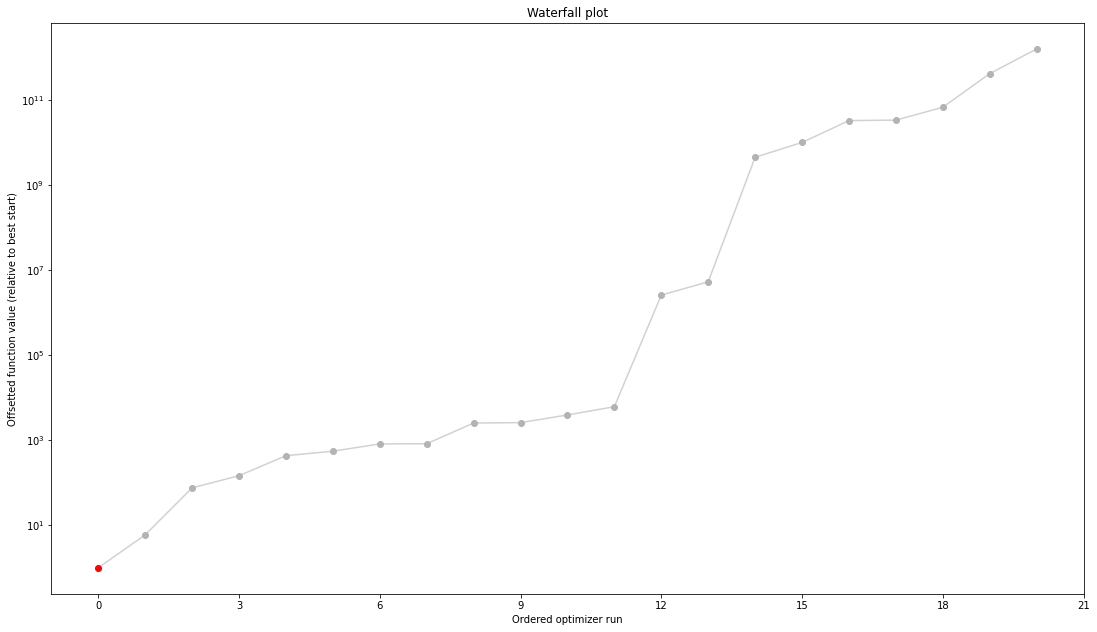

In [27]:
from pypesto.visualize import waterfall, parameters
waterfall(result)

[WARNING] /Users/ffroehlich/Documents/HMS/energy_modeling_chapter/venv/lib/python3.9/site-packages/pypesto/visualize/parameters.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xs = np.array(xs)



<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

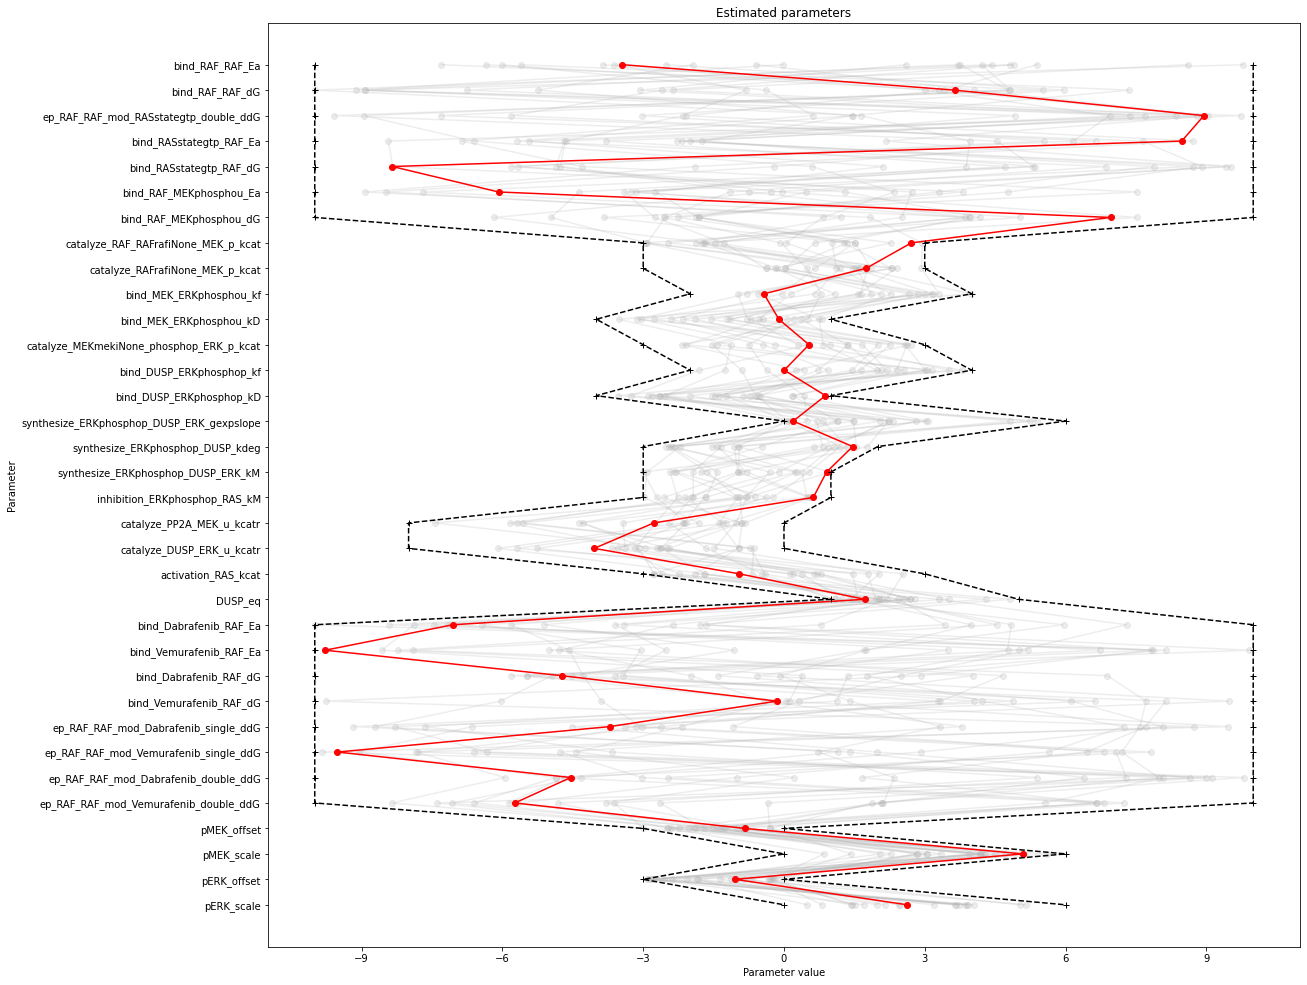

In [28]:
parameters(result)

In [29]:
visualization_table = pd.DataFrame([
    {
        petab.PLOT_ID: f'{rafi}_{obs}',
        petab.PLOT_TYPE_SIMULATION: petab.LINE_PLOT,
        petab.PLOT_TYPE_DATA: petab.MEAN_AND_SD,
        petab.DATASET_ID: condition,
        petab.X_VALUES: 'RAFi_0',
        petab.Y_VALUES: obs,
        petab.X_SCALE: petab.LOG10,
        petab.X_LABEL: rafi,
        petab.Y_LABEL: obs,
        petab.LEGEND_ENTRY: condition.split('__')[0]
    }
    for rafi in RAFis
    for obs in observable_table.index
    for condition in measurement_table[petab.DATASET_ID].unique()
    if condition.split('__')[1] == rafi
])

In [30]:
visualization_table

,plotId,plotTypeSimulation,plotTypeData,...,xLabel,yLabel,legendEntry
0,Vemurafenib_pMEK,LinePlot,MeanAndSD,...,Vemurafenib,pMEK,ctrl
1,Vemurafenib_pERK,LinePlot,MeanAndSD,...,Vemurafenib,pERK,ctrl
2,Dabrafenib_pMEK,LinePlot,MeanAndSD,...,Dabrafenib,pMEK,ctrl
3,Dabrafenib_pERK,LinePlot,MeanAndSD,...,Dabrafenib,pERK,ctrl


In [31]:
x = pypesto_problem.get_reduced_vector(result.optimize_result.list[0]['x'],
                                       pypesto_problem.x_free_indices)
simulation = pypesto_problem.objective(x, return_dict=True)
simulation_df = amici.petab_objective.rdatas_to_simulation_df(
    simulation['rdatas'],
    model=importer.create_model(),
    measurement_df=measurement_table,
)

Using existing amici model in folder /Users/ffroehlich/Documents/HMS/energy_modeling_chapter/amici_models/thermo_raf.


In [32]:
simulation_df = simulation_df.sort_values([petab.OBSERVABLE_ID, petab.PREEQUILIBRATION_CONDITION_ID, 
                                           petab.SIMULATION_CONDITION_ID]).reset_index()
measurement_table = measurement_table.sort_values([petab.OBSERVABLE_ID, petab.PREEQUILIBRATION_CONDITION_ID, 
                                                   petab.SIMULATION_CONDITION_ID]).reset_index()

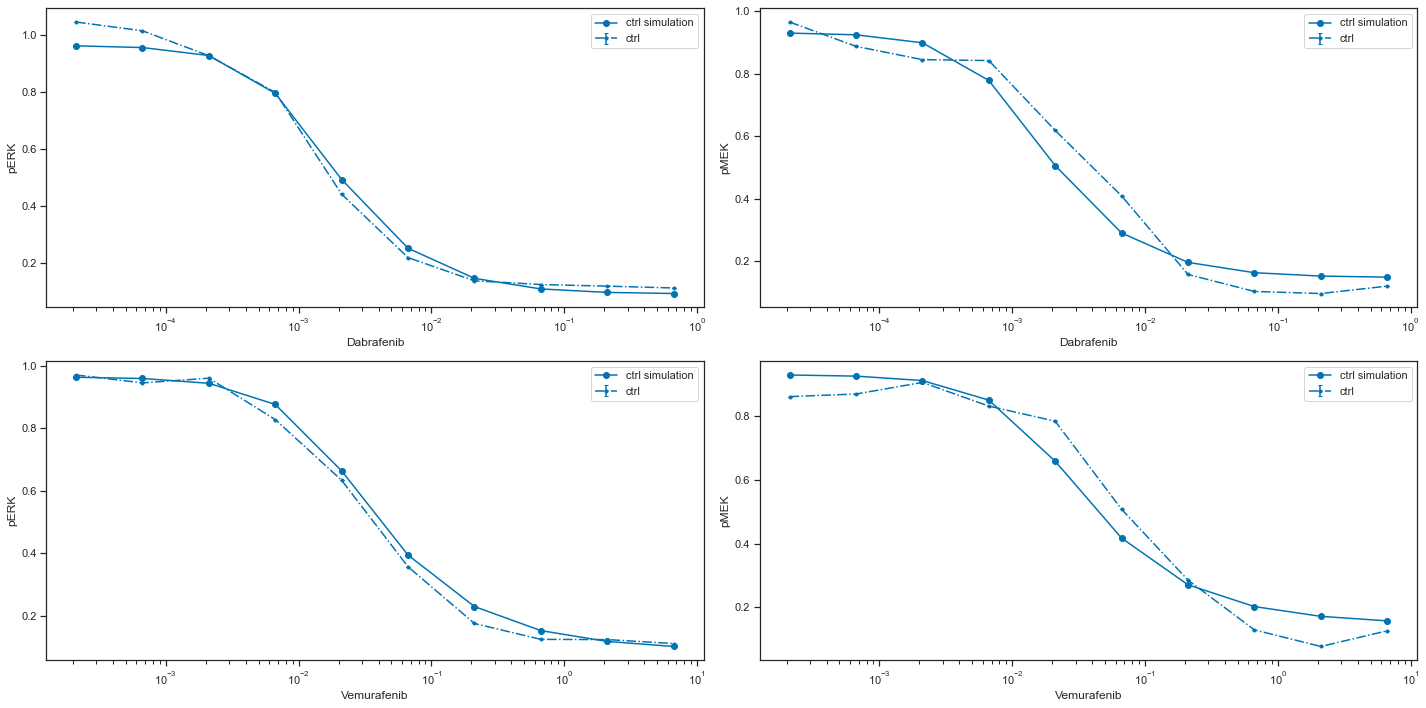

In [33]:
import petab.visualize
petab.visualize.plot_data_and_simulation(
    exp_data=measurement_table,
    exp_conditions=condition_table,
    sim_data=simulation_df,
    vis_spec=visualization_table
);

In [34]:
x_dict = dict(zip(pypesto_problem.x_names, result.optimize_result.list[0]['x']))
x_dict

{'BRAF_0': 3.0,
 'CRAF_0': 4.0,
 'bind_RAF_RAF_Ea': -3.443057109069805,
 'bind_RAF_RAF_dG': 3.6445178869529813,
 'bind_RAF_RAF_phi': 1.0,
 'bind_RAFi_RAF_phi': 1.0,
 'ep_RAF_RAF_mod_RASstategtp_double_ddG': 8.949881680612771,
 'bind_RASstategtp_RAF_Ea': 8.477294598313641,
 'bind_RASstategtp_RAF_dG': -8.345947689787295,
 'bind_RASstategtp_RAF_phi': 1.0,
 'bind_RAF_MEKphosphou_Ea': -6.082556495316562,
 'bind_RAF_MEKphosphou_dG': 6.960243894355478,
 'bind_RAF_MEKphosphou_phi': 1.0,
 'catalyze_RAF_RAFrafiNone_MEK_p_kcat': 2.7145359262374744,
 'catalyze_RAFrafiNone_MEK_p_kcat': 1.748957743996154,
 'bind_MEK_ERKphosphou_kf': -0.42828630197898704,
 'bind_MEK_ERKphosphou_kD': -0.10890569394292716,
 'catalyze_MEKmekiNone_phosphop_ERK_p_kcat': 0.5336282192056847,
 'bind_DUSP_ERKphosphop_kf': 0.005405773258701692,
 'bind_DUSP_ERKphosphop_kD': 0.8849259293749615,
 'synthesize_ERKphosphop_DUSP_ERK_gexpslope': 0.19620238646538288,
 'synthesize_ERKphosphop_DUSP_kdeg': 1.4653327428982346,
 'synthesize

In [35]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pypesto_problem.objective.x_names = [pypesto_problem.objective.x_names[ix] for ix in pypesto_problem.x_free_indices]
pypesto_problem.objective.check_grad_multi_eps(x, multi_eps=[1e-1, 1e-3, 1e-5],
                                               verbosity=0)

,grad,fd_f,fd_b,fd_c,fd_err,abs_err,rel_err,eps
bind_RAF_RAF_Ea,1.101362e-07,-0.176615,0.165767,-0.005424,0.342382,0.005424,0.057356,0.10000
bind_RAF_RAF_dG,6.998007e+00,11.807039,2.348403,7.077721,9.458635,0.079714,0.011106,0.10000
ep_RAF_RAF_mod_RASstategtp_double_ddG,0.000000e+00,-0.176627,0.176627,0.000000,0.353254,0.000000,0.000000,0.10000
bind_RASstategtp_RAF_Ea,0.000000e+00,-0.176627,0.176627,0.000000,0.353254,0.000000,0.000000,0.10000
bind_RASstategtp_RAF_dG,0.000000e+00,-0.176627,0.176627,0.000000,0.353254,0.000000,0.000000,0.10000
bind_RAF_MEKphosphou_Ea,-5.547505e+01,-67.335250,-40.993592,-54.164421,26.341658,1.310630,0.024198,0.00100
bind_RAF_MEKphosphou_dG,2.374412e+00,3.291511,1.497864,2.394687,1.793647,0.020275,0.008127,0.10000
catalyze_RAF_RAFrafiNone_MEK_p_kcat,0.000000e+00,-0.176627,0.176627,0.000000,0.353254,0.000000,0.000000,0.10000
catalyze_RAFrafiNone_MEK_p_kcat,1.073504e+02,106.134437,101.588323,103.861380,4.546114,3.489041,0.033593,0.00100
bind_MEK_ERKphosphou_kf,-7.382395e+01,-76.289137,-63.755920,-70.022529,12.533216,3.801418,0.054289,0.00100


In [36]:
simulation['rdatas'][0]['preeq_status']

array([[-2,  1,  0]])

In [37]:
optimizer_fine = FidesOptimizer(
    hessian_update=fides.HybridUpdate(),
    options={
        fides.Options.MAXTIME: 3600,
        fides.Options.SUBSPACE_DIM: fides.SubSpaceDim.TWO,
    }
)

In [38]:
optimize_options_fine = OptimizeOptions(
    startpoint_resample=False, allow_failed_starts=True,
)

In [39]:
pypesto_problem.x_guesses_full = np.vstack(result.optimize_result.get_for_key('x')[:10])

In [40]:
result_refined = minimize(
    pypesto_problem, optimizer_fine, n_starts=10, options=optimize_options_fine,
    engine=pypesto.engine.MultiThreadEngine(4)
)

Performing parallel task execution on 4 threads.
  0%|                                                                                                                                                                                                                                               | 0/10 [00:00<?, ?it/s]Executing task 0.
Executing task 1.
Executing task 2.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1804.70it/s]
Executing task 3.
2021-07-28 14:19:57,103 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 14:19:57,104 - fides - INFO -      0 | -5.680E+01 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 2.68E+02 |   NaN    |   NaN    |   NaN    | NaN  | N

2021-07-28 14:33:28,173 - fides - INFO -      4 | -3.239E+01 | -3.14E+01 | -5.83E+01 | +5.04E-01 | 1.00E+00 | 1.27E+03 | 3.63E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 14:33:29,523 - fides - INFO -      8 | -5.879E+01 | +4.77E-02 | -1.28E+00 | -3.79E-02 | 3.91E-03 | 3.04E+02 | 1.23E-02 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 14:34:07,616 - fides - INFO -     13 | -6.005E+01 | +8.46E-02 | -5.33E-01 | -1.59E-01 | 3.12E-02 | 2.73E+02 | 7.18E-02 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 14:34:12,425 - fides - INFO -     12 | -6.227E+01 | -1.30E+00 | -1.27E+00 | +9.61E-01 | 4.00E+00 | 8.91E+02 | 1.07E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 14:35:06,845 - fides - INFO -      9 | -5.883E+01 | -3.52E-02 | -7.14E-01 | +4.92E-02 | 9.77E-04 | 3.04E+02 | 3.50E-03 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 14:35:47,949 - fides - INFO -     14 | -6.005E+01 | +1.01E-01 | -5.07E-01 | -1.99E-01 | 7.81E-03 | 2.73E

2021-07-28 14:52:52,219 - fides - INFO -     19 | -5.883E+01 | +1.35E-04 | -3.79E-07 | -3.57E+02 | 9.31E-10 | 1.79E+02 | 2.58E-09 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 14:52:57,212 - fides - INFO -     24 | -6.005E+01 | +3.74E-07 | -5.18E-06 | -7.22E-02 | 7.45E-09 | 2.73E+02 | 2.64E-08 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 14:52:57,213 - fides - WARNING - Stopping as function difference 3.74E-07 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
Final fval=-60.0452, time=2022.7050s, n_fval=25.
Executing task 5.
2021-07-28 14:53:23,961 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 14:53:23,962 - fides - INFO -      0 | +4.970E+02 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 2.85E+01 |   NaN    |   NaN    |   NaN    | NaN  | NaN  | NaN  | 1
2021-07-28 14:53:27,734 - fides - INFO -   iter |    fval    | fva

2021-07-28 15:03:09,754 - fides - INFO -     17 | +4.945E+02 | +3.48E+00 | -9.05E-01 | -4.61E+00 | 5.00E-01 | 5.36E+01 | 1.64E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:03:10,235 - fides - INFO -     25 | -5.883E+01 | +1.92E-04 | -9.25E-11 | -2.07E+06 | 2.27E-13 | 1.79E+02 | 6.31E-13 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:03:32,514 - fides - INFO -     18 | +4.943E+02 | -2.28E-01 | -2.44E-01 | +9.20E-01 | 1.25E-01 | 5.36E+01 | 4.10E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:03:35,386 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 15:03:35,387 - fides - INFO -     10 | +3.204E+02 | +1.60E-02 | -6.71E-01 | -2.39E-02 | 2.25E-05 | 1.74E+04 | 4.24E-05 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:03:51,133 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   | 

2021-07-28 15:10:47,323 - fides - INFO -      1 | +5.540E+02 | -2.12E+02 | -1.85E+02 | +1.11E+00 | 1.00E+00 | 6.98E+02 | 1.55E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:11:02,635 - fides - INFO -     18 | +3.204E+02 | +0.00E+00 | -1.12E-05 | +0.00E+00 | 3.43E-10 | 1.74E+04 | 6.47E-10 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:11:12,670 - fides - INFO -     34 | -5.009E+01 | -7.74E+00 | -9.13E+00 | +7.72E-01 | 7.80E-01 | 1.44E+02 | 2.32E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:11:18,206 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 15:11:18,207 - fides - INFO -     30 | -6.216E+01 | +0.00E+00 | -3.62E-01 | +0.00E+00 | 7.57E-01 | 1.44E+01 | 2.12E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:11:42,821 - fides - INFO -     35 | -5.189E+01 | -1.80E+00 | -8.41E+00 | +7.38E-02 | 1.56E+00 | 

2021-07-28 15:18:33,432 - fides - WARNING - Stopping as maximum runtime 3600 is expected to be exceeded in the next iteration.
Final fval=-62.5598, time=3558.9206s, n_fval=38.
Executing task 8.
2021-07-28 15:18:54,656 - fides - INFO -     49 | -5.932E+01 | -1.81E-03 | -2.07E-03 | +8.68E-01 | 9.76E-02 | 2.90E+00 | 3.19E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:19:16,495 - fides - INFO -      5 | +2.099E+02 | -6.21E+01 | -5.66E+01 | +1.08E+00 | 2.50E-01 | 1.32E+03 | 5.42E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:19:28,567 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 15:19:28,577 - fides - INFO -     50 | -5.933E+01 | -2.03E-03 | -2.44E-03 | +8.13E-01 | 1.95E-01 | 3.86E+00 | 6.34E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:19:32,324 - fides - INFO -     12 | +6.131E+01 | -5.43E-01 | -7.31E-01 | +7.43E

2021-07-28 15:26:26,445 - fides - INFO -     12 | -3.047E-01 | -8.67E+00 | -8.93E+00 | +9.39E-01 | 5.00E-01 | 2.08E+02 | 1.37E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:26:44,715 - fides - INFO -     63 | -5.934E+01 | -7.88E-04 | -8.07E-04 | +9.52E-01 | 4.88E-02 | 1.30E+00 | 1.21E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:26:55,354 - fides - INFO -     23 | +4.544E+01 | -1.54E-02 | -1.91E-02 | +8.07E-01 | 9.47E-06 | 8.02E+02 | 2.71E-05 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:27:01,281 - fides - INFO -     24 | +4.544E+01 | +0.00E+00 | -3.18E-02 | +0.00E+00 | 1.89E-05 | 7.06E+02 | 4.90E-05 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:27:08,802 - fides - INFO -     25 | +4.544E+01 | +0.00E+00 | -7.98E-03 | +0.00E+00 | 4.73E-06 | 7.06E+02 | 1.23E-05 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:27:13,085 - fides - INFO -     13 | -3.047E-01 | +3.80E-01 | -1.27E+01 | -3.22E-01 | 1.00E+00 | 8.52E

2021-07-28 15:31:55,662 - fides - INFO -     74 | -5.934E+01 | +3.57E-04 | -1.53E-05 | -2.33E+01 | 1.49E-06 | 5.02E+00 | 3.78E-06 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:32:05,766 - fides - INFO -     35 | +4.544E+01 | +0.00E+00 | -6.57E-08 | +0.00E+00 | 3.61E-11 | 8.14E+02 | 8.94E-11 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:32:11,052 - fides - INFO -     36 | +4.544E+01 | +0.00E+00 | -1.64E-08 | +0.00E+00 | 9.03E-12 | 8.14E+02 | 2.24E-11 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:32:20,312 - fides - INFO -     21 | -5.480E+01 | +2.27E+00 | -9.40E-02 | -3.11E+01 | 4.00E+00 | 3.39E+01 | 1.48E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:32:20,573 - fides - INFO -     75 | -5.934E+01 | +2.33E-04 | -4.08E-06 | -5.71E+01 | 3.72E-07 | 5.02E+00 | 9.45E-07 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:32:37,089 - fides - INFO -      6 | +2.512E+03 | -2.69E-01 | -2.55E-01 | +1.06E+00 | 3.12E-02 | 1.41E

2021-07-28 15:38:13,930 - fides - INFO -     16 | +2.511E+03 | +0.00E+00 | -1.25E-02 | +0.00E+00 | 9.77E-04 | 9.59E+00 | 2.33E-03 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:38:18,574 - fides - INFO -     31 | -5.499E+01 | -2.74E-02 | -2.96E-02 | +9.03E-01 | 6.09E-02 | 7.50E+00 | 1.94E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:38:19,252 - fides - INFO -     89 | -5.934E+01 | +5.84E-04 | -1.23E-13 | -4.75E+09 | 1.11E-14 | 4.99E+00 | 2.82E-14 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:38:22,752 - fides - INFO -     43 | +4.544E+01 | +2.43E-05 | -1.00E-12 | -2.42E+07 | 5.51E-16 | 8.14E+02 | 1.36E-15 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 0
2021-07-28 15:38:22,753 - fides - WARNING - Stopping as trust region radius 1.38E-16 is smaller than machine precision.
Final fval=45.4380, time=1774.5021s, n_fval=44.
2021-07-28 15:38:42,288 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||s

2021-07-28 15:50:45,623 - fides - INFO -     56 | -5.615E+01 | -3.20E-02 | -3.79E-02 | +7.05E-01 | 1.22E-01 | 3.81E+00 | 3.78E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:51:21,273 - fides - INFO -     57 | -5.618E+01 | -2.52E-02 | -2.95E-02 | +7.79E-01 | 1.22E-01 | 1.02E+01 | 4.32E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:51:59,408 - fides - INFO -     58 | -5.621E+01 | -2.74E-02 | -4.35E-02 | +3.87E-01 | 2.43E-01 | 9.55E+00 | 8.91E-01 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:52:37,844 - fides - INFO -     59 | -5.623E+01 | -2.21E-02 | -2.29E-02 | +9.26E-01 | 2.43E-01 | 3.14E+01 | 1.01E+00 | 9.50E-01 | 1.00E+00 | 2d   |    0 |    0 | 1
2021-07-28 15:53:21,948 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 15:53:21,949 - fides - INFO -     60 | -5.623E+01 | +1.71E-02 | -4.60E-02 | -5.83E+00 | 4.87E-01 | 

[WARNING] /Users/ffroehlich/Documents/HMS/energy_modeling_chapter/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Offsetted function value (relative to best start)'>

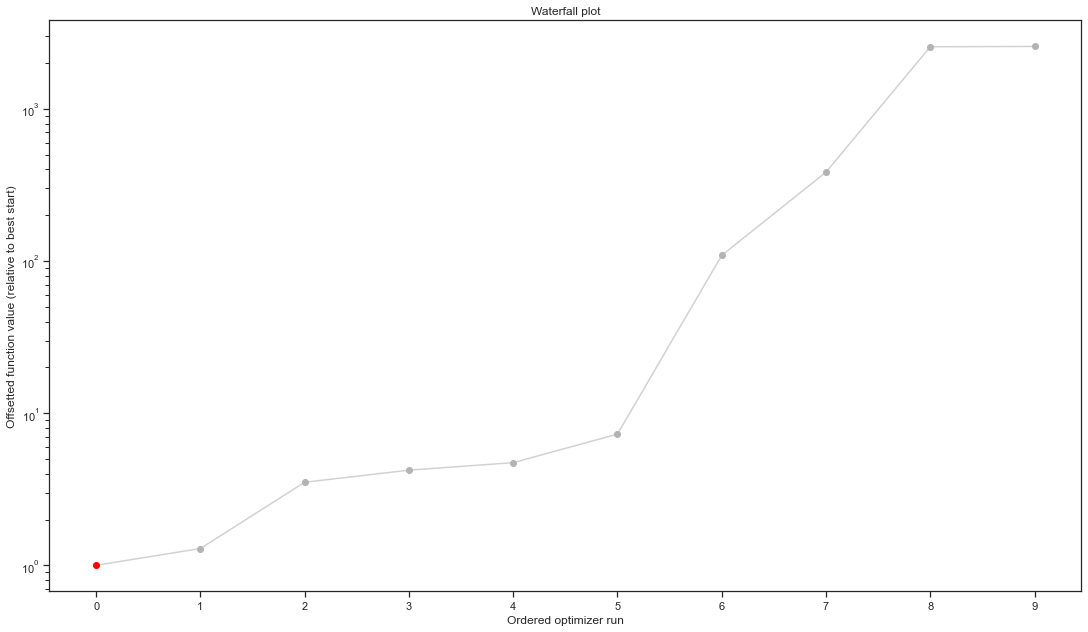

In [45]:
waterfall(result_refined)

In [41]:
x = pypesto_problem.get_reduced_vector(result_refined.optimize_result.list[0]['x'],
                                       pypesto_problem.x_free_indices)
simulation = pypesto_problem.objective(x, return_dict=True)
simulation_df = amici.petab_objective.rdatas_to_simulation_df(
    simulation['rdatas'],
    model=importer.create_model(),
    measurement_df=measurement_table,
)

Using existing amici model in folder /Users/ffroehlich/Documents/HMS/energy_modeling_chapter/amici_models/thermo_raf.


In [43]:
simulation_df = simulation_df.sort_values([petab.OBSERVABLE_ID, petab.PREEQUILIBRATION_CONDITION_ID, 
                                           petab.SIMULATION_CONDITION_ID]).reset_index()
measurement_table = measurement_table.sort_values([petab.OBSERVABLE_ID, petab.PREEQUILIBRATION_CONDITION_ID, 
                                                   petab.SIMULATION_CONDITION_ID]).reset_index()

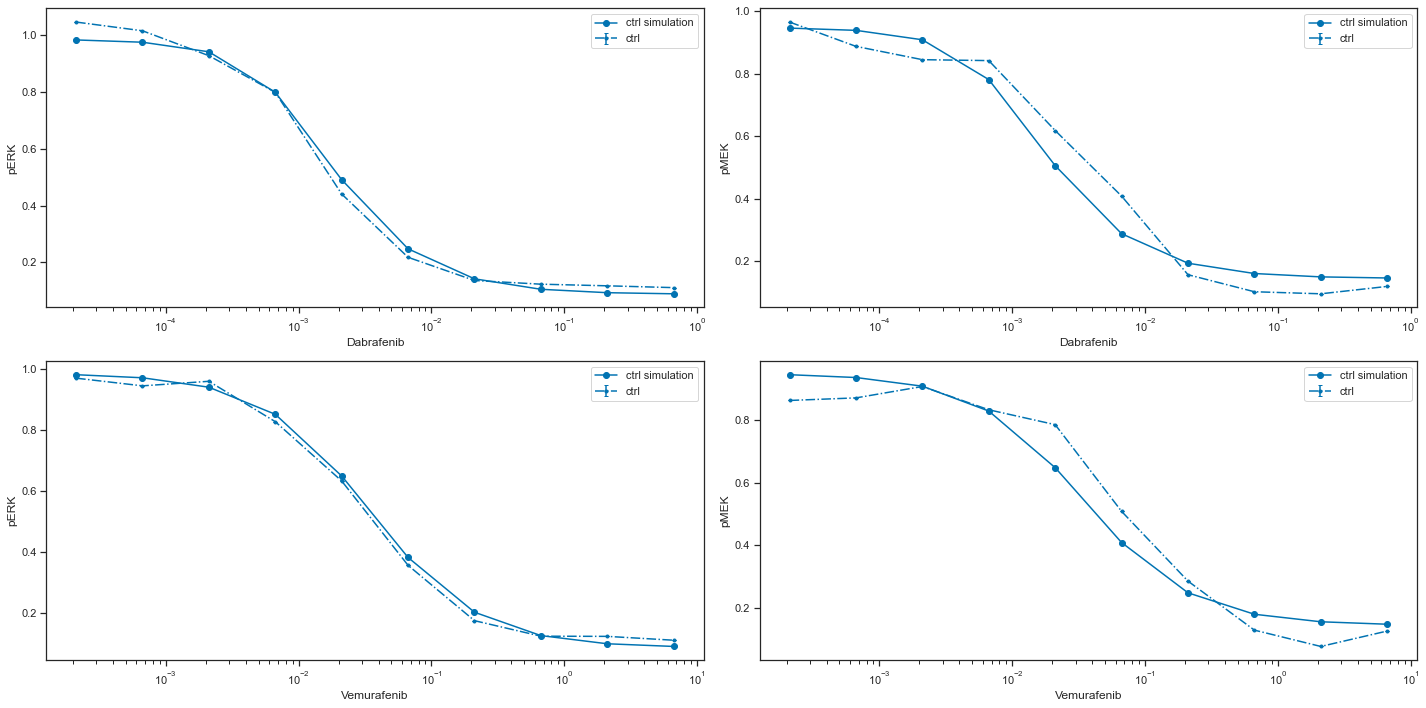

In [44]:
petab.visualize.plot_data_and_simulation(
    exp_data=measurement_table,
    exp_conditions=condition_table,
    sim_data=simulation_df,
    vis_spec=visualization_table
);